In [1]:
source('../load_environment.R')
options(repr.plot.width=8, repr.plot.height=4)

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Tue Jul 30 13:31:17 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


## Prepare data

In [2]:
qpcr <- read.csv("./datasets/pivot_bio_trials_qpcr.csv") 

# Recode factors
qpcr <- qpcr %>% rename(rate = inoc_rate) %>% mutate_at(c("trial","rep","rate","target_strain"), factor)

rate_levels <- c("Control","Lowest","Low","Medium","High")
qpcr$rate <- factor(qpcr$rate, levels = rate_levels)
qpcr$rate_num <- as.numeric(qpcr$rate)
qpcr$trt <- factor(qpcr$trt, levels = c('UTC','PROVEN40'), labels = c('Uninoculated Control','PROVEN 40'))
qpcr$target_strain <- factor(qpcr$target_strain, levels = c('6-5687','137-2253'), labels = c('Ks6-5687','Kv137-2253'))

head(qpcr)

,trial,rep,n_rate,rate,trt,target_strain,copies_per_g_fw,rate_num
,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,IA03451,1,Low,Control,Uninoculated Control,Kv137-2253,0.000000,1
2,IA03451,1,Low,Control,Uninoculated Control,Ks6-5687,0.000000,1
3,IA03451,1,Low,Low,PROVEN 40,Kv137-2253,8.129116,3
4,IA03451,1,Low,Low,PROVEN 40,Ks6-5687,0.000000,3
5,IA03451,1,Low,Medium,PROVEN 40,Kv137-2253,24.776915,4
6,IA03451,1,Low,Medium,PROVEN 40,Ks6-5687,0.000000,4


## First try

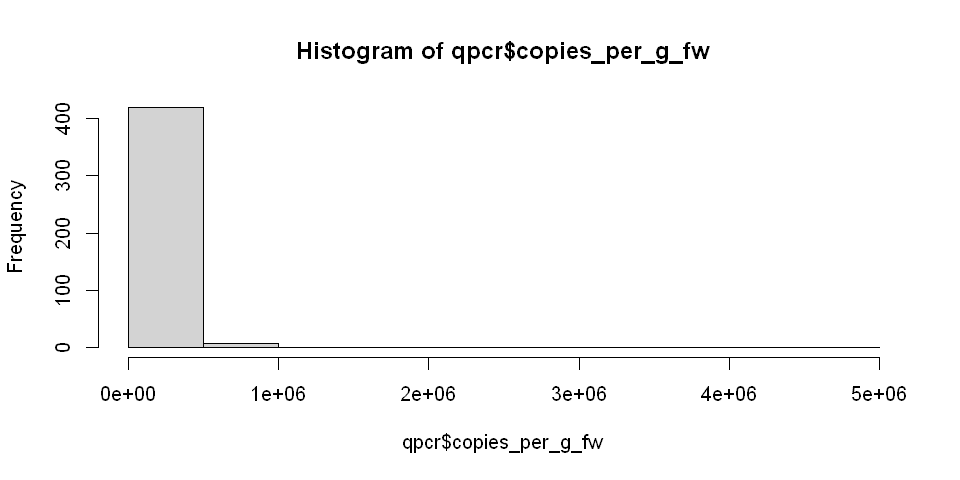

In [3]:
hist(qpcr$copies_per_g_fw)

## Model terms
- `rate` = Fixed effect of inoculation rate
- `target_strain` = fixed effect of the target strain is the primer looking for
- `1|trial/rep/rate` = Random effect of the plot within the rep within the trial (note: 2 plants were sampled from each plot)

In [4]:
qpcr_mod_1 <- lmer(copies_per_g_fw ~ rate*target_strain + (1|trial/rep), data = qpcr)

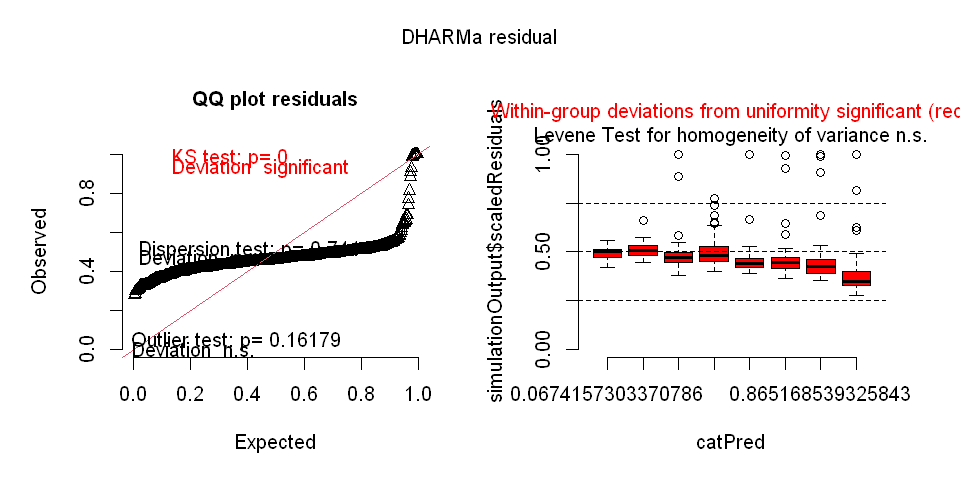

In [5]:
qpcr_mod_1_sims  <- simulateResiduals(fittedModel = qpcr_mod_1, plot = T)

### Lots of issues:

- Lots of zeroes
- High variance

Consider a log transformation to deal with high variance. Becasue of the zeores in the data we'll use:

`log(y + 1)`

This will keep the zeroes intact. 

## Model 2

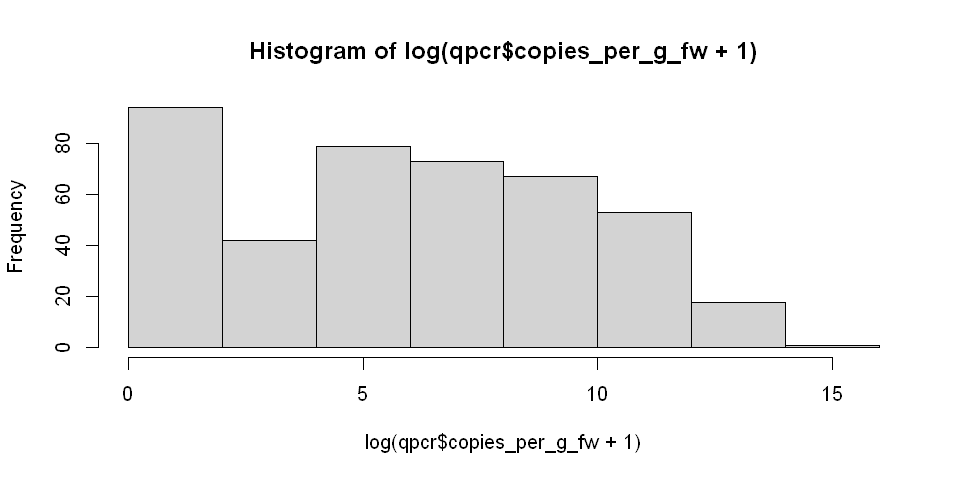

In [6]:
hist(log(qpcr$copies_per_g_fw+1))

In [7]:
qpcr_mod_2 <- lmer(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep), data = qpcr)

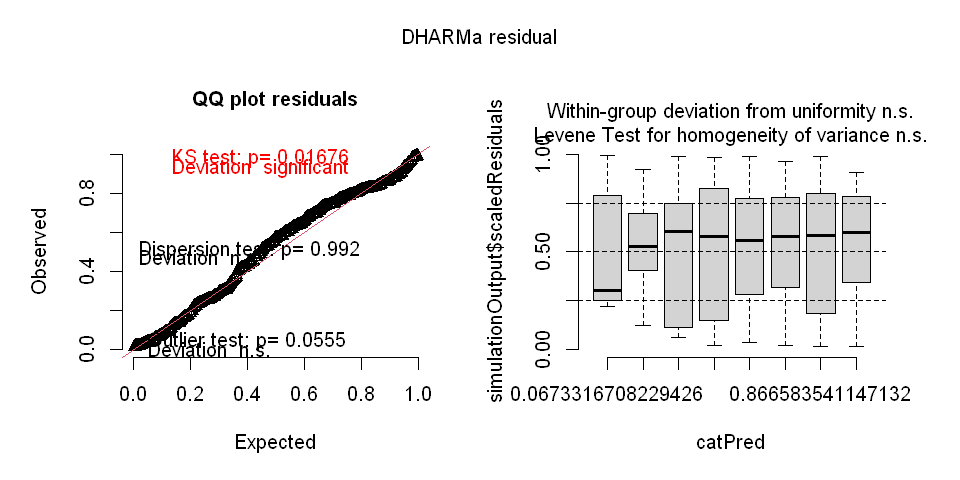

In [8]:
qpcr_mod_2_sims  <- simulateResiduals(fittedModel = qpcr_mod_2, plot = T)


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = Inf, p-value < 2.2e-16
alternative hypothesis: two.sided


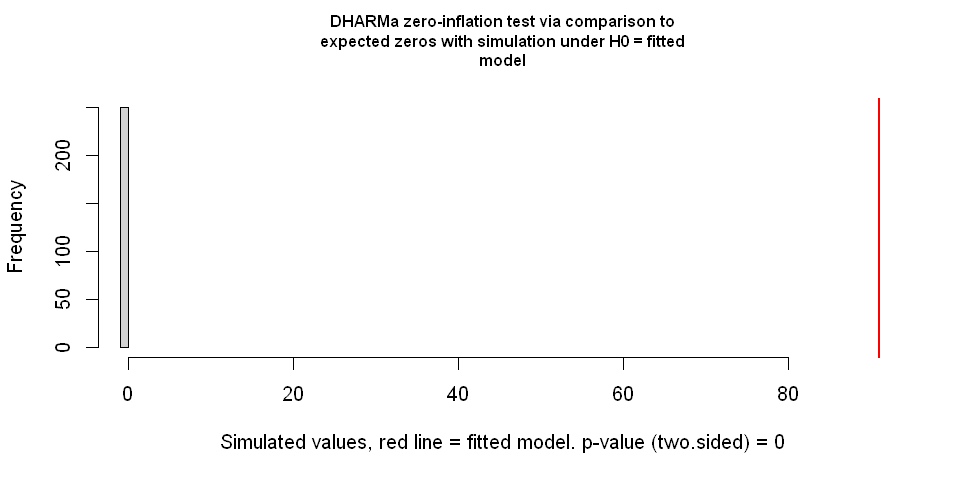

In [9]:
testZeroInflation(qpcr_mod_2)

OK, better. But still have the issue with the zero-inflation. 

## Model 3

Try to fit a zero-inflated model to deal with this. 

A zero-inflated model adds structural zeros to allow for the higher number of zeros than expected by a normal distribution. 

The probability of having a structural zero is always modeled with a logit link to keep it between 0 and 1, i.e.

`logit(p)=β0+ β1x + ... + β1n`

where p is the probability of having a structural zero. 

Will use `glmmTMB` to acomplisht this. More about  glmmTMB here: https://rpubs.com/mmcgillycuddy/737181


In [10]:
qpcr_mod_3 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi=~., # This is the zero-inflated model specification. For now, we keep the same as the conditional model
                        #dispformula = ~  rate, # ErrVar = 0
                        family = "gaussian",
                        data = qpcr)

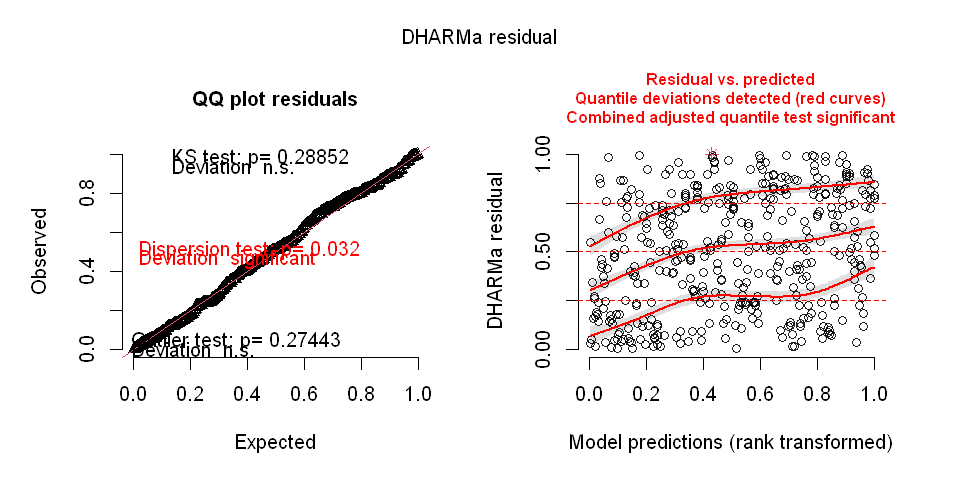

In [11]:
qpcr_mod_3_sims  <- simulateResiduals(fittedModel = qpcr_mod_3, plot = T)


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = 0.98196, p-value = 1
alternative hypothesis: two.sided


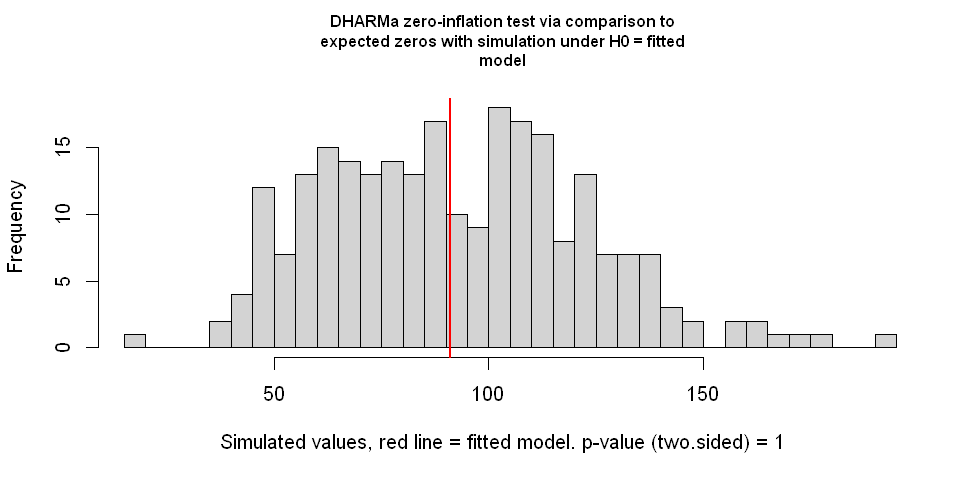

In [12]:
testZeroInflation(qpcr_mod_3)

In [13]:
BIC(qpcr_mod_2,qpcr_mod_3)

,df,BIC
,<dbl>,<dbl>
qpcr_mod_2,11,2192.622
qpcr_mod_3,21,1905.981


This model helped with dealing with the zero-infation, but it the residuals still appear a bit overdispersed (i.e., residual variance is larger than expected under the fitted model), particularly in the 3rd and 4th quartilies of the data.

If overdispersion is present, confidence intervals tend to be too narrow, and p-values to small, leading to inflated type I error. 


## Model 4
One possible reason for overdispersion is that the model might be overparameterized. Try relaxing the zero inflation model by only making it dependent on fixed effects.   

In [14]:
qpcr_mod_4 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi = ~  rate*target_strain, 
                        family = "gaussian",
                        data = qpcr)

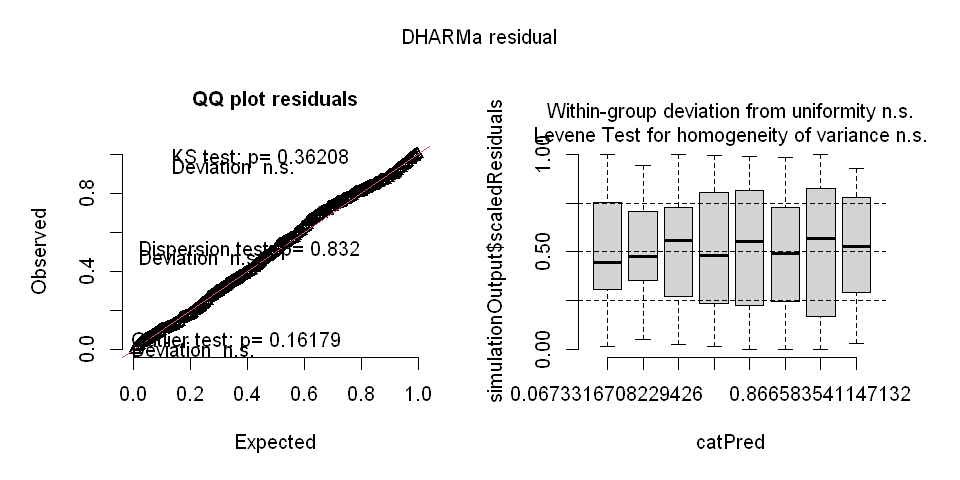

In [15]:
qpcr_mod_4_sims  <- simulateResiduals(fittedModel = qpcr_mod_4, plot = T)

In [16]:
anova(qpcr_mod_3,qpcr_mod_4)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
qpcr_mod_4,19,1907.141,1984.220,-934.5706,1869.141,NA,NA,NA
qpcr_mod_3,21,1820.788,1905.981,-889.3941,1778.788,90.35297,2,2.399393e-20


In [17]:
VarCorr(qpcr_mod_3)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.56426 
 trial     (Intercept) 1.59561 
 Residual              2.06225 

Zero-inflation model:
 Groups    Name        Std.Dev.  
 rep:trial (Intercept) 0.00021547
 trial     (Intercept) 1.79148126
 Residual              2.06224961

In [18]:
VarCorr(qpcr_mod_4)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.59371 
 trial     (Intercept) 1.59272 
 Residual              2.05442 

The more relaxed model `qpcr_mod_4` seemed to have helped with the lingering overdispersion. However, the fit to the data was significanlty reduced. Plus, there is reason to believe that zero data should also be driven my environmental contrains and not solely technical (e.g., specificity of the primers). So there appears to be risk of underfitting the data. 

## Model 5

We might be able to deal with the overdispersion instead by modeling the variance as a function of our predictors.We begin to check whether there is significantly different variances among groups of data

In [19]:
# test for HOV across treatments
leveneTest(log(copies_per_g_fw + 1) ~ rate, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ target_strain, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ trial, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ paste0(trial,rep), data=qpcr)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,3.146683,0.02501305
,423,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,3.366774,0.06722263
,425,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,8,1.897645,0.05878729
,418,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,53,0.9613747,0.554254
,373,NA,NA


There seems to be diffences in variance between rates and strains. We add the model via the `dispformula` argument. 

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
qpcr_mod_3,21,1820.788,1905.981,-889.3941,1778.788,NA,NA,NA
qpcr_mod_5,25,1826.236,1927.656,-888.1181,1776.236,2.551925,4,0.6353626


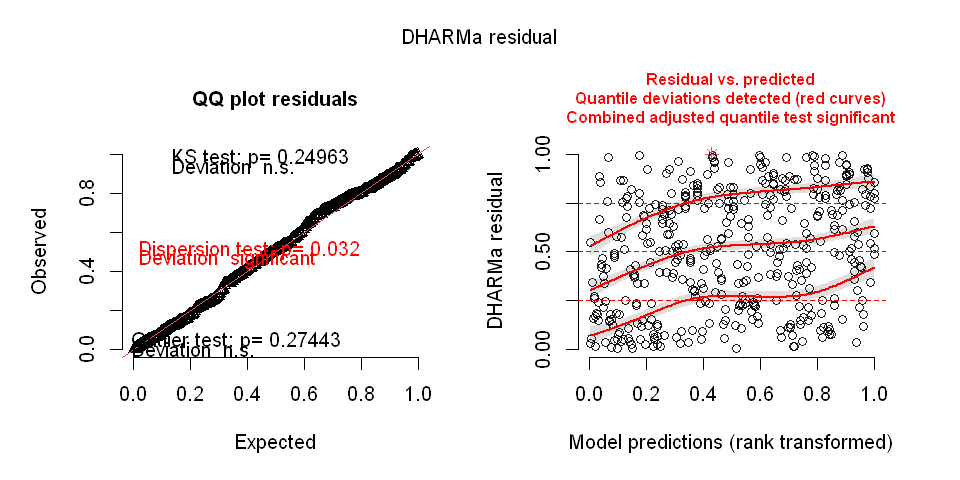

In [20]:
qpcr_mod_5 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi=~., # This is the zero-inflated model specification. For now, we keep the same as the conditional model
                        dispformula  = ~ rate + target_strain,
                        family = "gaussian",
                        data = qpcr)

qpcr_mod_5_sims  <- simulateResiduals(fittedModel = qpcr_mod_5, plot = T)
anova(qpcr_mod_5,qpcr_mod_3)

## Chosen model

While `qpcr_mod_5` appears to be a bit overparemeterized without significant gain in the fit, the overdispersion seemed to be resolved. Thus we move ahead with this model.



In [21]:
qpcr_mod <- qpcr_mod_5
summary(qpcr_mod)

 Family: gaussian  ( identity )
Formula:          
log(copies_per_g_fw + 1) ~ rate * target_strain + (1 | trial/rep)
Zero inflation:                            ~.
Dispersion:                                ~rate + target_strain
Data: qpcr

     AIC      BIC   logLik deviance df.resid 
  1826.2   1927.7   -888.1   1776.2      402 

Random effects:

Conditional model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.3499   0.5915  
 trial     (Intercept) 2.5266   1.5895  
 Residual                  NA       NA  
Number of obs: 427, groups:  rep:trial, 54; trial, 9

Zero-inflation model:
 Groups    Name        Variance  Std.Dev.
 rep:trial (Intercept) 5.197e-08 0.000228
 trial     (Intercept) 3.189e+00 1.785678
 Residual                     NA       NA
Number of obs: 427, groups:  rep:trial, 54; trial, 9

Conditional model:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          5.4097     0.6987   7.743 9.74e-15 **

Note: The zero-inflation model estimates the probability of an extra zero, so `Estimate <0` indicates fewer absences (i.e., zeroes)
 

The zero-inflation model estimates the probability of an extra zero, so `Estimate <0` indicates fewer absences (i.e., zeroes)

In [22]:
VarCorr(qpcr_mod)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.59155 
 trial     (Intercept) 1.58952 
 Residual                   NA 

Zero-inflation model:
 Groups    Name        Std.Dev.  
 rep:trial (Intercept) 0.00022797
 trial     (Intercept) 1.78567775
 Residual                      NA

In [23]:
qpcr_mod_zi_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain, component = "zi", type = "response")

In [24]:
qpcr_mod_zi_means$emmeans

target_strain = Ks6-5687:
 rate    response     SE  df lower.CL upper.CL
 Control    0.637 0.1094 402    0.466    0.841
 Low        0.443 0.0493 402    0.387    0.602
 Medium     0.427 0.0401 402    0.383    0.565
 High       0.404 0.0263 402    0.376    0.506

target_strain = Kv137-2253:
 rate    response     SE  df lower.CL upper.CL
 Control    0.423 0.0382 402    0.381    0.557
 Low        0.384 0.0130 402    0.371    0.443
 Medium     0.374 0.0055 402    0.369    0.405
 High       0.382 0.0119 402    0.371    0.438

Confidence level used: 0.95 
Intervals are back-transformed from the log[logit(mu + 1)] scale 

In [25]:
qpcr_mod_zi_means$contrasts

target_strain = Ks6-5687:
 contrast         odds.ratio     SE  df null t.ratio p.value
 Low / Control          1.21 0.1220 402 2.72  -3.110  0.0058
 Medium / Control       1.16 0.0907 402 2.72  -3.568  0.0012
 High / Control         1.09 0.0540 402 2.72  -4.228  0.0001

target_strain = Kv137-2253:
 contrast         odds.ratio     SE  df null t.ratio p.value
 Low / Control          1.32 0.2475 402 2.72  -1.891  0.1511
 Medium / Control       1.10 0.0896 402 2.72  -2.775  0.0163
 High / Control         1.28 0.2207 402 2.72  -1.997  0.1206

P value adjustment: dunnettx method for 3 tests 
Tests are performed on the log[log odds ratio] scale 

In [26]:
# Expected marginal means from the conditional model
qpcr_mod_cond_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain,  component = "cond", type ="response")

In [27]:
qpcr_mod_cond_means$emmeans

target_strain = Ks6-5687:
 rate    response   SE  df lower.CL upper.CL
 Control      223  156 402     55.6      882
 Low          571  369 402    159.9     2031
 Medium      2862 1884 402    784.0    10437
 High        3304 2060 402    969.2    11254

target_strain = Kv137-2253:
 rate    response   SE  df lower.CL upper.CL
 Control      184  115 402     53.5      629
 Low         1232  745 402    375.0     4043
 Medium      2911 1799 402    863.4     9808
 High        5070 3058 402   1549.1    16590

Confidence level used: 0.95 
Intervals are back-transformed from the log(mu + 1) scale 

In [28]:
qpcr_mod_cond_means$contrasts

target_strain = Ks6-5687:
 contrast         ratio    SE  df null t.ratio p.value
 Low / Control     2.56  1.44 402    1   1.664  0.2346
 Medium / Control 12.80  7.42 402    1   4.401  <.0001
 High / Control   14.78  8.01 402    1   4.969  <.0001

target_strain = Kv137-2253:
 contrast         ratio    SE  df null t.ratio p.value
 Low / Control     6.65  2.80 402    1   4.509  <.0001
 Medium / Control 15.71  6.94 402    1   6.239  <.0001
 High / Control   27.36 11.43 402    1   7.925  <.0001

P value adjustment: dunnettx method for 3 tests 
Tests are performed on the log scale 

## Add output from the zero inflation model

In [29]:
qpcr_mod_cond_means_table <- data.frame(qpcr_mod_cond_means$contrasts) %>% 
    transmute(target_strain, rate = factor(gsub(" / Control","",contrast),levels = rate_levels),
    plab = ifelse(p.value < 0.001,"p<0.001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_cond_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)# %>% 

qpcr_mod_cond_means_table

qpcr_mod_zi_means_table <- data.frame(qpcr_mod_zi_means$contrasts) %>% 
    transmute(target_strain, rate = factor(gsub(" / Control","",contrast),levels = rate_levels),
    plab = ifelse(p.value < 0.001,"p<0.001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_zi_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)# %>% 

qpcr_mod_zi_means_table

Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,Low,p=0.23,570.6888,368.7693,402,159.85402,2030.8306,PROVEN 40
Ks6-5687,Medium,p<0.001,2861.5965,1883.8748,402,784.04183,10437.2449,PROVEN 40
Ks6-5687,High,p<0.001,3303.5898,2060.0555,402,969.24803,11254.1776,PROVEN 40
Kv137-2253,Low,p<0.001,1232.0580,745.0049,402,374.95904,4043.1429,PROVEN 40
Kv137-2253,Medium,p<0.001,2910.8381,1798.9847,402,863.35450,9808.4023,PROVEN 40
Kv137-2253,High,p<0.001,5070.2523,3057.6264,402,1549.05725,16590.3870,PROVEN 40
Ks6-5687,Control,NA,222.5697,156.2070,402,55.60917,881.9558,Uninoculated Control
Kv137-2253,Control,NA,184.3322,115.4176,402,53.48230,629.4440,Uninoculated Control


Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,Low,p=0.0058,0.4432469,0.049313264,402,0.3872685,0.6017863,PROVEN 40
Ks6-5687,Medium,p=0.0012,0.4274295,0.040138070,402,0.3828355,0.5648537,PROVEN 40
Ks6-5687,High,p<0.001,0.4040748,0.026332431,402,0.3762290,0.5058162,PROVEN 40
Kv137-2253,Low,p=0.15,0.3840098,0.013045648,402,0.3711097,0.4429193,PROVEN 40
Kv137-2253,Medium,p=0.016,0.3736186,0.005501006,402,0.3687443,0.4045648,PROVEN 40
Kv137-2253,High,p=0.12,0.3822855,0.011934614,402,0.3706587,0.4377278,PROVEN 40
Ks6-5687,Control,NA,0.6369613,0.109392695,402,0.4664407,0.8405950,Uninoculated Control
Kv137-2253,Control,NA,0.4231516,0.038214825,402,0.3813285,0.5574620,Uninoculated Control


In [30]:
names(qpcr_mod_cond_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_cond_means_table))
names(qpcr_mod_cond_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_cond_means_table))
names(qpcr_mod_cond_means_table) <- gsub("emmean","response",names(qpcr_mod_cond_means_table))

names(qpcr_mod_zi_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_zi_means_table))
names(qpcr_mod_zi_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_zi_means_table))
names(qpcr_mod_zi_means_table) <- gsub("emmean","response",names(qpcr_mod_zi_means_table))

In [31]:
p1 <- qpcr_mod_cond_means_table %>% 
mutate(model = "Conditional model") %>% 
ggplot(aes(x =rate,response, fill = target_strain)) + 
facet_wrap(~model, scales = "free") +
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0.3, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL*1.5), hjust = 0.85, size = 2.5, position = position_dodge(width = 0.5)) + 
scale_y_log10(breaks = c(10,100,1000,10000,100000)) +
#coord_cartesian(ylim  = c(10,100000), xlim = c(0.3,5.8), expand = F) +
scale_fill_manual(values = myColorPalette) +
#scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
labs(y = "Copies per g of root fresh weight", x = "Inoculation rate treatment", fill = "Primer strain target:") + 
theme(axis.text.x = element_text(vjust = 0)) 

In [32]:
p2 <- qpcr_mod_zi_means_table %>% 
mutate(model = "Zero-inflation model") %>% 
ggplot(aes(x = rate,response, fill = target_strain)) + 
facet_wrap(~model, scales = "free") +
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0.3, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL + 0.05), hjust = 0.15, size = 2.5, position = position_dodge(width = 0.5)) + 
#coord_cartesian(ylim  = c(0,1), xlim = c(0.3,5.8), expand = F) +
scale_fill_manual(values = myColorPalette) +
#scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
labs(y = "Prob. of zero copies", x = "Inoculation rate treatment", fill = "Primer strain target:") + 
theme(axis.text.x = element_text(vjust = 0)) 

Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


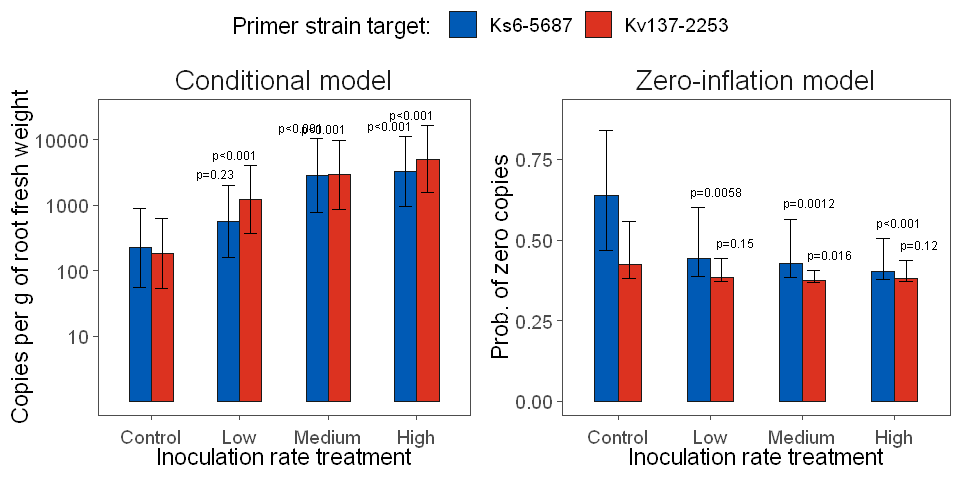

In [33]:
options(repr.plot.width=8, repr.plot.height=4)

ggarrange(p1,p2, common.legend = TRUE)

In [34]:
qpcr_mod_comb_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain, component = "response", type= "response")

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"
Warning message in checkTerms(data.tmb1$termszi, data.tmb0$termszi):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"


In [35]:
qpcr_mod_comb_means$emmeans

target_strain = Ks6-5687:
 rate    response     SE  df lower.CL upper.CL
 Control     10.5   11.2 402     0.68     77.3
 Low        174.1  152.3 402    30.69    966.6
 Medium     866.2  806.2 402   138.46   5391.8
 High      1543.8 1192.4 402   337.74   7043.9

target_strain = Kv137-2253:
 rate    response     SE  df lower.CL upper.CL
 Control     88.2   63.0 402    21.28    356.4
 Low        907.5  568.8 402   264.37   3109.4
 Medium    2572.6 1590.1 402   762.91   8669.4
 High      3653.2 2330.8 402  1041.87  12803.2

Confidence level used: 0.95 
Intervals are back-transformed from the log(mu + 1) scale 

In [36]:
qpcr_mod_comb_means$contrasts

target_strain = Ks6-5687:
 contrast         ratio     SE  df null t.ratio p.value
 Low / Control     15.3  11.36 402    1   3.661  0.0008
 Medium / Control  75.6  58.65 402    1   5.574  <.0001
 High / Control   134.6 107.72 402    1   6.128  <.0001

target_strain = Kv137-2253:
 contrast         ratio     SE  df null t.ratio p.value
 Low / Control     10.2   5.32 402    1   4.444  <.0001
 Medium / Control  28.8  16.66 402    1   5.819  <.0001
 High / Control    41.0  21.43 402    1   7.096  <.0001

P value adjustment: dunnettx method for 3 tests 
Tests are performed on the log scale 

In [37]:
qpcr_mod_comb_means_table <- data.frame(qpcr_mod_comb_means$contrasts) %>% 
    transmute(target_strain, rate = factor(gsub(" / Control","",contrast),levels = rate_levels),
    plab = ifelse(p.value < 0.0001,"p<0.0001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_comb_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)


Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


In [38]:
names(qpcr_mod_comb_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_comb_means_table))
names(qpcr_mod_comb_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_comb_means_table))
names(qpcr_mod_comb_means_table) <- gsub("emmean|estimate","response",names(qpcr_mod_comb_means_table))

In [39]:
qpcr_mod_comb_means_table

target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,Low,p=0.00084,174.10688,152.26676,402,30.6878841,966.63857,PROVEN 40
Ks6-5687,Medium,p<0.0001,866.21820,806.18815,402,138.4569523,5391.82830,PROVEN 40
Ks6-5687,High,p<0.0001,1543.78210,1192.37963,402,337.7360710,7043.87042,PROVEN 40
Kv137-2253,Low,p<0.0001,907.53238,568.76408,402,264.3735957,3109.44919,PROVEN 40
Kv137-2253,Medium,p<0.0001,2572.59934,1590.08877,402,762.9080566,8669.43293,PROVEN 40
Kv137-2253,High,p<0.0001,3653.20128,2330.75767,402,1041.8730290,12803.23086,PROVEN 40
Ks6-5687,Control,NA,10.47345,11.21200,402,0.6802644,77.34489,Uninoculated Control
Kv137-2253,Control,NA,88.22650,62.97881,402,21.2779575,356.36530,Uninoculated Control


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


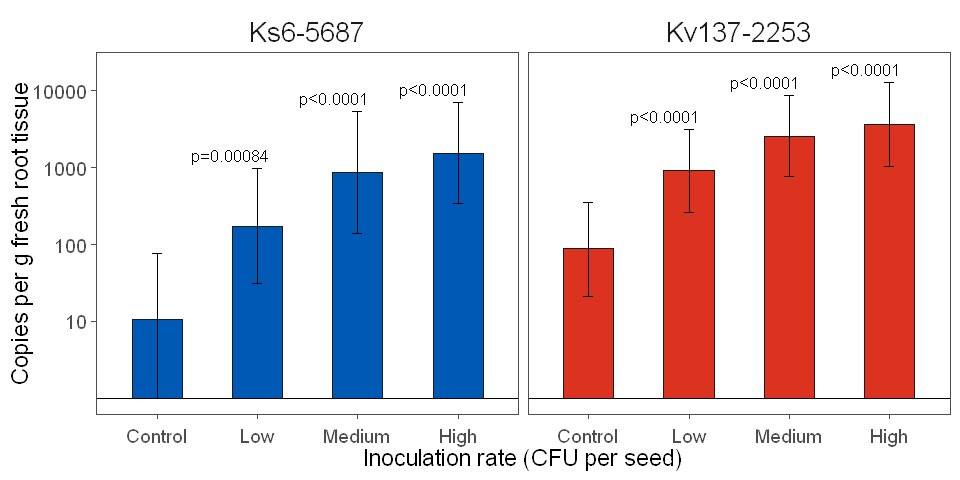

In [40]:
options(repr.plot.width=8, repr.plot.height=4)

qpcr_mod_comb_means_table %>% 
ggplot(aes(x = (as.factor(rate)),response, fill = target_strain)) + 
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = pmax(1,lower.CL)), width = 0.1, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL*1.5), hjust = 0.85, size = 3.5, position = position_dodge(width = 0.5)) + 
geom_hline(yintercept = 1) + 
scale_y_log10(breaks = c(10,100,1000,10000,100000)) +
#coord_cartesian(#ylim  = c(1,100000), xlim = c(0.3,5.8), expand = T) +
scale_fill_manual(values = myColorPalette) +
#scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
facet_wrap(~target_strain) + 
labs(y = "Copies per g fresh root tissue", x = "Inoculation rate (CFU per seed)") + 
theme(axis.text.x = element_text(vjust = 0), legend.position = "none") 

#ggsave("./figures/strain_colonization.jpeg",width = 8, height = 4)

Warning message in geom_col(colour = "gray10", width = 0.5, aes(shape = target_strain), :
"Ignoring unknown aesthetics: shape"
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


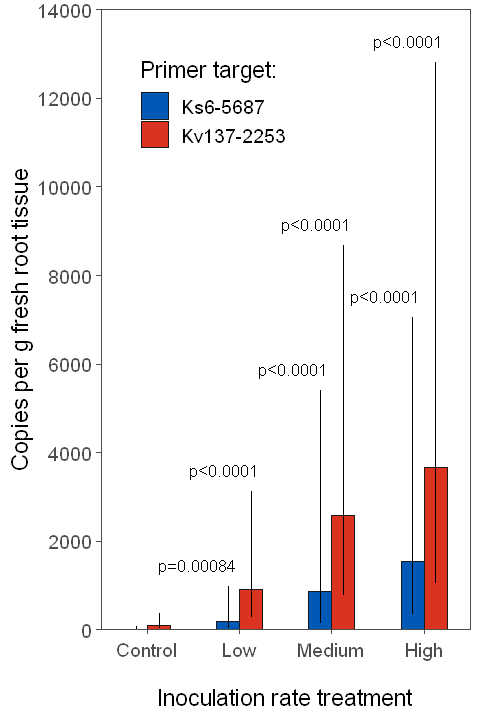

In [41]:
options(repr.plot.width=4, repr.plot.height=6)

qpcr_mod_comb_means_plot <- qpcr_mod_comb_means_table %>% 
ggplot(aes(x = rate,response, fill = target_strain)) + 
geom_col(colour = "gray10", width = 0.5, aes(shape = target_strain), position = position_dodge(width = 0.5)) + 
geom_errorbar(aes(ymax = upper.CL, ymin = pmax(1,lower.CL)), width = 0, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL + 500), hjust = 0.9, size = 3.5, position = position_dodge(width = 0.5)) +
#geom_point(aes(shape = target_strain), colour = "gray10", size = 5, width = 0.5, position = position_dodge(width = 0.5)) + 
geom_hline(yintercept = 1) + 
scale_y_continuous(breaks = c(0:12*2000)) +
coord_cartesian(ylim  = c(0,ceiling(max(qpcr_mod_comb_means_table$upper.CL + 1000)/1000)*1000), xlim = c(0.5,length(rate_levels) - 0.5), expand = F) +
scale_fill_manual(values = myColorPalette) +
scale_shape_manual(values = c(21,23)) + 
#scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
labs(y = "Copies per g fresh root tissue", x = "\nInoculation rate treatment", fill = "Primer target:", shape = "Primer target:") + 
theme(axis.text.x = element_text(vjust = 0), legend.position = c(0.3,0.85)
) 

qpcr_mod_comb_means_plot

ggsave(plot = qpcr_mod_comb_means_plot, "./figures/strain_colonization.jpeg",width = 4, height = 6)
saveRDS(qpcr_mod_comb_means_plot, "./figures/qpcr_plot.rds")

In [42]:
emmeans(qpcr_mod,  trt.vs.ctrl ~ target_strain, component = "response", type= "response")$contrast

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"
Warning message in checkTerms(data.tmb1$termszi, data.tmb0$termszi):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"


 contrast                  ratio   SE  df null t.ratio p.value
 (Kv137-2253) / (Ks6-5687)   4.1 2.07 402    1   2.800  0.0054

Results are averaged over the levels of: rate 
Tests are performed on the log scale 

In [43]:
1/4.1 

[1] 0.2439024

## Check if there is evidence of increse with Inoculation rate

In [44]:
qpcr_lin_mod_1 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate_num * target_strain  + (1|trial/rep),
                        zi=~.,
                        #dispformula  = ~ rate + target_strain,
                        family = "gaussian",
                        data = qpcr)

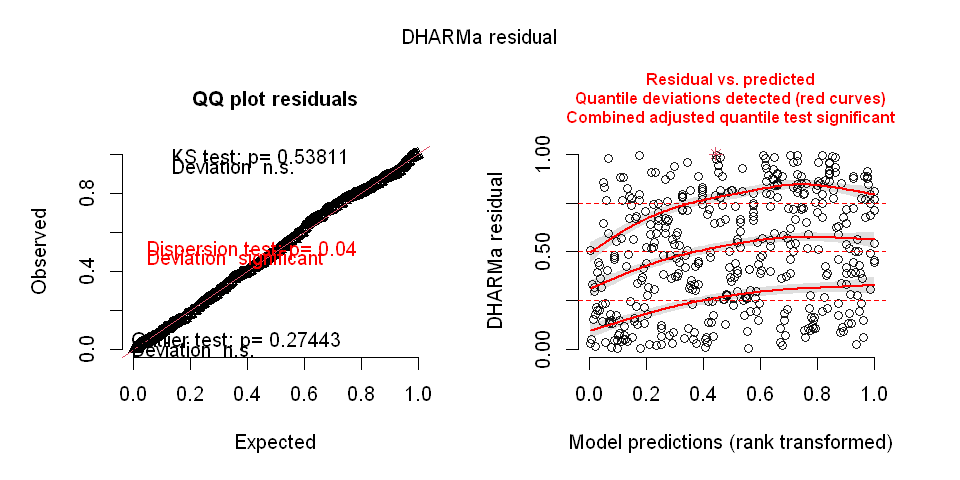

In [45]:
options(repr.plot.width=8, repr.plot.height=4)
qpcr_lin_mod_1_sim  <- simulateResiduals(fittedModel = qpcr_lin_mod_1, plot = T)


In [46]:
Anova(qpcr_lin_mod_1,"III")
summary(qpcr_lin_mod_1)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),38.97818920,1,4.285670e-10
rate_num,32.49690335,1,1.193826e-08
target_strain,0.02822764,1,8.665748e-01
rate_num:target_strain,0.42518344,1,5.143619e-01


 Family: gaussian  ( identity )
Formula:          
log(copies_per_g_fw + 1) ~ rate_num * target_strain + (1 | trial/rep)
Zero inflation:                            ~.
Data: qpcr

     AIC      BIC   logLik deviance df.resid 
  1812.9   1865.7   -893.5   1786.9      414 

Random effects:

Conditional model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.2926   0.5409  
 trial     (Intercept) 2.5449   1.5953  
 Residual              4.3241   2.0795  
Number of obs: 427, groups:  rep:trial, 54; trial, 9

Zero-inflation model:
 Groups    Name        Variance  Std.Dev. 
 rep:trial (Intercept) 6.372e-08 0.0002524
 trial     (Intercept) 3.081e+00 1.7551687
 Residual              4.324e+00 2.0794534
Number of obs: 427, groups:  rep:trial, 54; trial, 9

Dispersion estimate for gaussian family (sigma^2): 4.32 

Conditional model:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        4.5688     0.7318   6.243 4.29e-10 ***
r